# Migrant Flows - Sankey Diagram Demo

A demonstration of how to use the `ipysankeywidget` package to generate a Sankey diagram from a `pandas` dataframe.

This notebook also demonstrates how widget libraries can also be thought of as *code generators* capable of generating reusable code that can be used directly elsewhere, or can be treated as an automatically generated "first draft" of the code for interactive chart that can be further enhanced and edited by hand to produce a more polished production quality output.

Originally motivated by Oli Hawkins' [Internal migration flows in the UK](http://olihawkins.com/visualisation/8) [[about](http://olihawkins.com/2017/03/1)].

In [1]:
#!pip3 install ipysankeywidget
#!jupyter nbextension enable --py --sys-prefix ipysankeywidget

In [34]:
import pandas as pd
#Read in the CSV file
#If we specify the null character and thousands separator, the flows whould be read in as numerics not strings
df=pd.read_csv("rdemos/laandregionsquarematrices2015/regionsquarematrix2015.csv",
               skiprows = 8,thousands=',',na_values='-')
df.head()

,DESTINATION,Region,E12000001,E12000002,E12000003,E12000004,E12000005,E12000006,E12000007,E12000008,E12000009,W92000004,S92000003,N92000002
0,North East,E12000001,NaN,6870.0,10820.0,3580.0,2360.0,3560.0,4400.0,4580.0,2250.0,1010.0,3350.0,630.0
1,North West,E12000002,6670.0,NaN,22930.0,11130.0,15000.0,8020.0,14870.0,12240.0,7570.0,10190.0,6000.0,2150.0
2,Yorkshire and The Humber,E12000003,10830.0,22050.0,NaN,19280.0,8470.0,9530.0,11230.0,10680.0,5710.0,2910.0,3690.0,620.0
3,East Midlands,E12000004,3030.0,10300.0,19520.0,NaN,19180.0,20820.0,16010.0,19050.0,6980.0,3140.0,2310.0,540.0
4,West Midlands,E12000005,2260.0,13440.0,8220.0,17110.0,NaN,9390.0,17760.0,16540.0,13250.0,8260.0,2230.0,540.0


In [1]:
from ipysankeywidget import SankeyWidget

In [94]:
#The widget requires an edgelist with source, target and value columns
dfm=pd.melt(df,id_vars=['DESTINATION','Region'], var_name='source', value_name='value')
dfm.columns=['DESTINATION','target','source','value']
dfm['target']=dfm['target']+'_'
dfm.head()

,DESTINATION,target,source,value
0,North East,E12000001_,E12000001,NaN
1,North West,E12000002_,E12000001,6670.0
2,Yorkshire and The Humber,E12000003_,E12000001,10830.0
3,East Midlands,E12000004_,E12000001,3030.0
4,West Midlands,E12000005_,E12000001,2260.0


In [95]:
#The SankeyWidget function expects a list of dicts, each dict specifying an edge
#Also check how to drop rows where the weight is NA
dfm.dropna()[['source','target','value']].to_dict(orient='records')[:3]

[{'source': 'E12000001', 'target': 'E12000002_', 'value': 6670.0},
 {'source': 'E12000001', 'target': 'E12000003_', 'value': 10830.0},
 {'source': 'E12000001', 'target': 'E12000004_', 'value': 3030.0}]

In [96]:
#Generate and display default styled Sankey diagram
SankeyWidget(value={'links': dfm.dropna()[['source','target','value']].to_dict(orient='records')},
             width=800, height=800,margins=dict(top=0, bottom=0))

### Adding Colour

We can also add a colour mapping to the chart - provide the mapping based on the first letter of the area code:

In [89]:
colormap={'E':'#ffcc00','N':'green','S':'blue','W':'red'}
dfm['color']=dfm['source'].apply(lambda x: colormap[x[0]])
SankeyWidget(value={'links': dfm.dropna()[['source','target','value','color']].to_dict(orient='records')},
             width=800, height=800,margins=dict(top=0, bottom=0))

### Dropping Migration Flows Between Regions of the Same Country

The original diagram just showed flows between nations, and did not include intra-nation flows.

So let's drop flows between regions of the same country - that is, flows where the leading country code is the same for both the source and the target:

In [90]:
links=dfm[dfm['source'].str[0]!=dfm['target'].str[0]].dropna()[['source','target','value','color']].to_dict(orient='records')}
SankeyWidget(value={'links': links,
             width=800, height=800,margins=dict(top=0, bottom=0))

### Aggregating Counts For Regions in the Same Country

The original diagram aggregated counts for regions within a particular country. So let's do the same...

Start by defining a country mapping - we can also use this to label the country nodes rather more meaningfully.

Note that to prevent circularity, we distinguish between the source and target nodes by naming them slightly differently: the target node label identifiers have whitespace to distinguish them from the source node label identifiers.

In [91]:
countrymap={'E':'England','N':'Northern Ireland','S':'Scotland','W':'Wales'}
dfm['countrysource']=dfm['source'].apply(lambda x: countrymap[x[0]])
dfm['countrytarget']=dfm['target'].apply(lambda x: countrymap[x[0]]+' ')

Aggregate (sum) the counts on a country-country flow basis, as well as colouring by source country:

In [92]:
dfm2 = dfm[dfm['source'].str[0]!=dfm['target'].str[0]].dropna().groupby(['countrysource','countrytarget']).aggregate(sum).reset_index()
dfm2.columns=['source','target','value']
dfm2['color']=dfm2['source'].apply(lambda x: colormap[x[0]])
dfm2

,source,target,value,color
0,England,Northern Ireland,8120.0,#ffcc00
1,England,Scotland,42990.0,#ffcc00
2,England,Wales,55800.0,#ffcc00
3,Northern Ireland,England,8350.0,green
4,Northern Ireland,Scotland,2420.0,green
5,Northern Ireland,Wales,410.0,green
6,Scotland,England,35540.0,blue
7,Scotland,Northern Ireland,1930.0,blue
8,Scotland,Wales,1320.0,blue
9,Wales,England,54570.0,red


Now we can render this table to give a country-country migrant flow Sankey diagram:

In [97]:
s=SankeyWidget(value={'links': dfm2.to_dict(orient='records')},
             width=800, height=800,margins=dict(top=0, bottom=0,left=150,right=120))
s

### Generating Outputs

One of the under-appreciated benefits that arises from using widget libraries to generate rich interactive outputs for use in live documents is that the generated code can also be reused elsewhere.

For example, it's not hard to see the benefits that might arise from being able to generate a flat image rendering of a generated chart such that that image can be reused elsewhere: 

In [108]:
#Save a png version
s.save_png('images/mySankey.png')

*Render the saved png as an image in a markdown cell:*

![](images/mySankey.png)

But in many cases we can also render output code.

Some widget libraries generate HTML output files (or HTML fragments) from code templates, enriched with suitably formatted data when the output widget is generated.

In this case, the widget that is produced is an SVG file - which we can export as such, and then reuse directly elsewhere, or use as a first draft of our own customised version of the output chart:

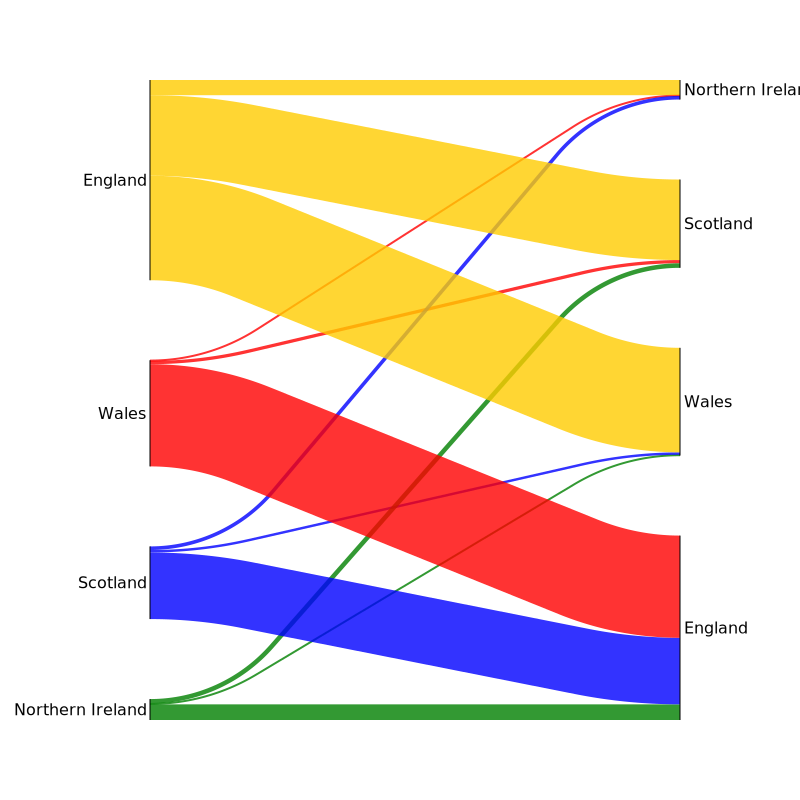

In [109]:
#save svg
s.save_svg('images/mySankey.svg')

from IPython.display import SVG, display
display(SVG('images/mySankey.svg'))